In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

In [3]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import numpy as np
import pandas as pd

from authorship_tool.types_ import (
    AuthorColl4dStr,
    AuthorCollection,
    Doc3dStr,
    Para2dStr,
)
from authorship_tool.util import dim_reshaper, text_reader, type_guard
from authorship_tool.util.dim_reshaper import reduce_dim
from authorship_tool.util.path_util import DatasetPaths, VijiniDatasetPaths
from authorship_tool.util.serializer import author_collection_to_csv
from authorship_tool.util.tokenizer import tokenize_para

Project root: /workspaces/shap-authorship-analysis-demo
Path: dump/text_data = /workspaces/shap-authorship-analysis-demo/dump/text_data
Path: data/john_blake_2023/wordLists/adjectivesPastParticiple = /workspaces/shap-authorship-analysis-demo/data/john_blake_2023/wordLists/adjectivesPastParticiple
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset = /workspaces/shap-authorship-analysis-demo/data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017 = /workspaces/shap-authorship-analysis-demo/data/uoa-thesis-2014-2017
Path: dump/processed_text = /workspaces/shap-authorship-analysis-demo/dump/processed_text
Path: dump/dataset = /workspaces/shap-authorship-analysis-demo/dump/dataset
Path: dump/lgbm/model = /workspaces/shap-authorship-analysis-demo/dump/lgbm/model
Path: dump/shap/figure = /workspaces/sha

In [4]:
fully_generated_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_fully_gen
hybrid_dataset_path: Final[Path] = DatasetPaths.vijini_dataset_hybrid
output_path: Final[Path] = VijiniDatasetPaths.processed_text_dir

In [5]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [6]:
DatasetName: TypeAlias = str

full_gen_dataset_files: list[Path] = [
    file
    for file in fully_generated_dataset_path.iterdir()
    if file.with_suffix(".txt").exists()
]
hybrid_dataset_files: list[Path] = [
    file for file in hybrid_dataset_path.iterdir() if file.with_suffix(".txt").exists()
]

dataset_files: list[Path] = sorted(full_gen_dataset_files + hybrid_dataset_files)
dataset_names: list[DatasetName] = [id.name for id in dataset_files]

for idx, file_id in enumerate(dataset_names):
    print(f"#{idx+1}\t{file_id}")

#1	2110.09779_generated.txt
#2	2110.09779_original.txt
#3	2110.10319_generated.txt
#4	2110.10319_original.txt
#5	2110.10329_generated.txt
#6	2110.10329_original.txt
#7	2110.10340_generated.txt
#8	2110.10340_original.txt
#9	2110.10478_generated.txt
#10	2110.10478_original.txt
#11	2110.10575_generated.txt
#12	2110.10575_original.txt
#13	2110.10577_generated.txt
#14	2110.10577_original.txt
#15	2110.10778_generated.txt
#16	2110.10778_original.txt
#17	2110.10817_generated.txt
#18	2110.10817_original.txt
#19	2110.11115_generated.txt
#20	2110.11115_original.txt
#21	2110.11205_generated.txt
#22	2110.11205_original.txt
#23	2110.11207_generated.txt
#24	2110.11207_original.txt
#25	2110.11589_generated.txt
#26	2110.11589_original.txt
#27	2110.11879_generated.txt
#28	2110.11879_original.txt
#29	2110.11984_generated.txt
#30	2110.11984_original.txt
#31	2110.12010_generated.txt
#32	2110.12010_original.txt
#33	2110.12341_generated.txt
#34	2110.12341_original.txt
#35	2110.12383_generated.txt
#36	2110.12

In [7]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for name in dataset_names
    if (match := re.search(r"_(.+?)\.txt", name)) is not None
}

In [8]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    authors_files: list[Path] = [
        file_id for file_id in dataset_files if re.match(r".*"+author+r"\.txt$" ,file_id.name)
    ]

    author_collection: AuthorCollection = text_reader.read_multi_documents(
        authors_files
    )
    doc: Doc3dStr = [tokenize_para(para) for doc in author_collection for para in doc]
    author_para: list[Para2dStr] = [para for para in doc]

    para_num: NumOfParas = len(author_para)
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	generatedAbstract - 100 paragraphs
2:	generated - 100 paragraphs
3:	original - 100 paragraphs
4:	originalAbstract - 100 paragraphs


In [9]:
AUTHOR_A: Final[str] = "original"
AUTHOR_B: Final[str] = "generated"
AUTHOR_C: Final[str] = "generatedAbstract"
AUTHOR_D: Final[str] = "originalAbstract"

In [10]:
import re

files_a: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_A + r"\.txt$", file_id.name)
]

docs_a: AuthorColl4dStr = [
    [tokenize_para(para)]
    for doc in text_reader.read_multi_documents(files_a)
    for para in doc
]

In [11]:
files_b: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_B + r"\.txt$", file_id.name)
]

docs_b: AuthorColl4dStr = [
    [tokenize_para(para)]
    for doc in text_reader.read_multi_documents(files_b)
    for para in doc
]

In [12]:
files_c: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_C + r"\.txt$", file_id.name)
]

docs_c: AuthorColl4dStr = [
    [tokenize_para(para)]
    for doc in text_reader.read_multi_documents(files_c)
    for para in doc
]

In [13]:
files_d: list[Path] = [
    file_id
    for file_id in dataset_files
    if re.match(r".*" + AUTHOR_D + r"\.txt$", file_id.name)
]

docs_d: AuthorColl4dStr = [
    [tokenize_para(para)]
    for doc in text_reader.read_multi_documents(files_d)
    for para in doc
]

In [14]:
author_collection_to_csv(docs_a, AUTHOR_A, output_path)
author_collection_to_csv(docs_b, AUTHOR_B, output_path)
author_collection_to_csv(docs_c, AUTHOR_C, output_path)
author_collection_to_csv(docs_d, AUTHOR_D, output_path)

+---------------+------------------+-------------------+------------------+-------------------+----------+----------+-------------+-------------+----------+----------+-------------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+------------+---------------+-----------+-----------+-----------+---------------+---------------+-----------+------------+-----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------

In [15]:
# docs_a, docs_bをlist[Para2dStr]に変換
paras_a: list[Para2dStr] = reduce_dim(docs_c)
paras_b: list[Para2dStr] = reduce_dim(docs_d)

In [16]:
from authorship_tool.types_ import Tag
from authorship_tool.util.feature.pos import PosFeature


all_paras: list[Para2dStr] = paras_a + paras_b
all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos
print(all_pos)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_pp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [17]:
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)


dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]

In [19]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [20]:
datasets: pd.DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [21]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)

In [22]:
df = datasets.iloc[:, :-1]
display(df.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_pp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,TO,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,177,177,True,True,True,False,False,7.769130,12.571429,False,False,False,False,False,False,True,False,True,True,False,0.672316,5.282486,0.225989,0.723164,0.225989,0.0,0.0,0.011299,0.011299,0.045198,0.039548,0.005650,0.033898,0.011299,0.084746,0.000000,0.000000,0.084746,0.175141,0.000000,0.00565,0.0,0.005650,0.203390,0.067797,0.0,0.039548,0.0,0.0,0.005650,0.000000,0.005650,0.000000,0.0,0.000000,0.028249,0.016949,0.005650,0.022599,0.033898,0.022599,0.028249,0.000000,0.000000,0.000000,0.005650,0.0
1,113,113,True,True,True,False,False,5.727613,5.600000,False,False,False,False,False,False,True,False,False,True,False,0.778761,5.159292,0.230088,0.787611,0.230088,0.0,0.0,0.017699,0.017699,0.026549,0.053097,0.008850,0.017699,0.000000,0.026549,0.000000,0.000000,0.106195,0.185841,0.008850,0.00000,0.0,0.008850,0.132743,0.070796,0.0,0.132743,0.0,0.0,0.000000,0.008850,0.008850,0.008850,0.0,0.000000,0.035398,0.026549,0.000000,0.017699,0.026549,0.044248,0.008850,0.000000,0.000000,0.000000,0.000000,0.0
2,264,264,False,True,True,False,False,6.887670,10.666667,False,True,False,False,False,False,True,False,False,True,False,0.549242,5.295455,0.155303,0.674242,0.155303,0.0,0.0,0.000000,0.000000,0.037879,0.034091,0.003788,0.011364,0.003788,0.121212,0.000000,0.000000,0.125000,0.098485,0.000000,0.00000,0.0,0.000000,0.200758,0.030303,0.0,0.098485,0.0,0.0,0.026515,0.015152,0.022727,0.000000,0.0,0.000000,0.034091,0.034091,0.000000,0.026515,0.011364,0.049242,0.003788,0.000000,0.003788,0.000000,0.007576,0.0
3,176,176,True,True,False,False,False,10.687480,14.600000,False,True,False,True,False,False,True,False,False,True,False,0.573864,5.250000,0.107955,0.681818,0.107955,0.0,0.0,0.005682,0.005682,0.045455,0.034091,0.000000,0.056818,0.000000,0.068182,0.005682,0.000000,0.102273,0.125000,0.000000,0.00000,0.0,0.000000,0.102273,0.045455,0.0,0.147727,0.0,0.0,0.011364,0.005682,0.039773,0.000000,0.0,0.000000,0.028409,0.051136,0.011364,0.022727,0.022727,0.039773,0.011364,0.005682,0.000000,0.000000,0.005682,0.0
4,194,194,False,True,True,False,False,9.035079,11.500000,False,True,False,True,False,False,True,False,False,False,False,0.597938,5.231959,0.139175,0.685567,0.139175,0.0,0.0,0.000000,0.000000,0.056701,0.036082,0.005155,0.030928,0.000000,0.123711,0.000000,0.000000,0.092784,0.134021,0.000000,0.00000,0.0,0.000000,0.221649,0.015464,0.0,0.046392,0.0,0.0,0.015464,0.005155,0.025773,0.000000,0.0,0.000000,0.025773,0.020619,0.005155,0.056701,0.030928,0.020619,0.025773,0.005155,0.000000,0.000000,0.000000,0.0
5,190,190,True,False,False,False,False,11.703828,12.166667,True,True,False,False,False,False,True,False,False,True,False,0.642105,5.100000,0.105263,0.668421,0.105263,0.0,0.0,0.005263,0.005263,0.052632,0.036842,0.000000,0.021053,0.000000,0.063158,0.000000,0.005263,0.100000,0.131579,0.005263,0.00000,0.0,0.005263,0.142105,0.031579,0.0,0.073684,0.0,0.0,0.036842,0.010526,0.036842,0.005263,0.0,0.000000,0.052632,0.057895,0.000000,0.052632,0.000000,0.036842,0.021053,0.000000,0.000000,0.005263,0.005263,0.0
6,267,267,True,True,False,False,False,8.842983,11.100000,True,True,True,True,True,False,True,False,False,False,False,0.550562,4.973783,0

In [23]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])

array([ True,  True,  True,  True,  True])

In [24]:
print(df.shape)

(200, 67)


In [25]:
print(df.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [26]:
print(df.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [27]:
from authorship_tool.util.ml.model import LGBMSource, Score, TrainingResult
from authorship_tool.util.ml import cv_trainer, trainer
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)

In [28]:
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 82, number of negative: 78
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512500 -> initscore=0.050010
[LightGBM] [Info] Start training from score 0.050010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [29]:
score: Score | None = result.score

In [30]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.2828282828282829
f1 score: 0.35000000000000003
accuracy score: 0.35


In [31]:
from authorship_tool.util.ml.model import pred_crosstab, dump

display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,7,15
True,11,7


In [32]:
dump(result, VijiniDatasetPaths)

In [33]:
from shap import Explainer
import shap

test_data: pd.DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.shap_expected_val
shap_vals = result.shap_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0

In [34]:
shap.initjs()

In [35]:
SHAP_FIGURE_DIR: Path = VijiniDatasetPaths.shap_figure_dir

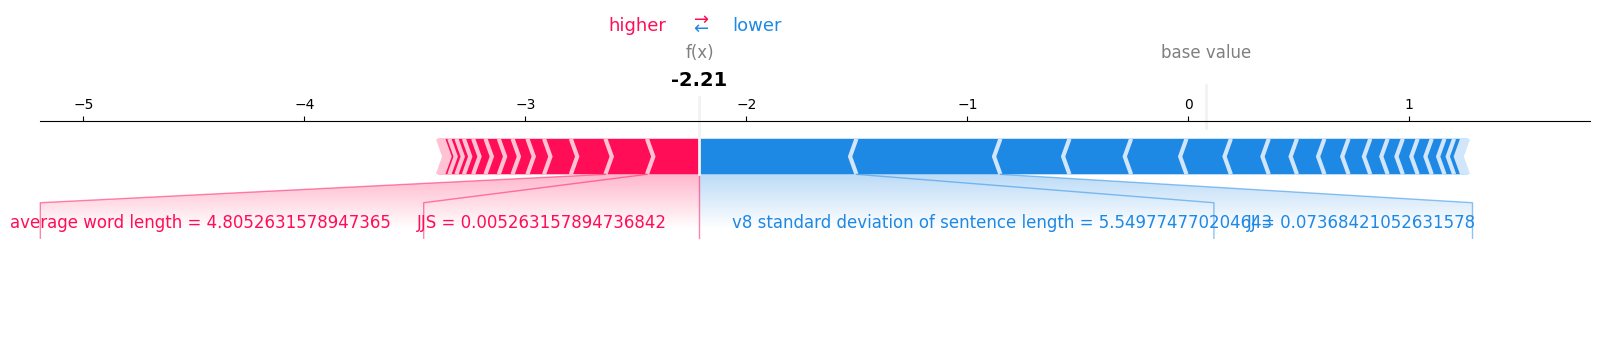

<Figure size 640x480 with 0 Axes>

In [36]:
from matplotlib import pyplot as plt

shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

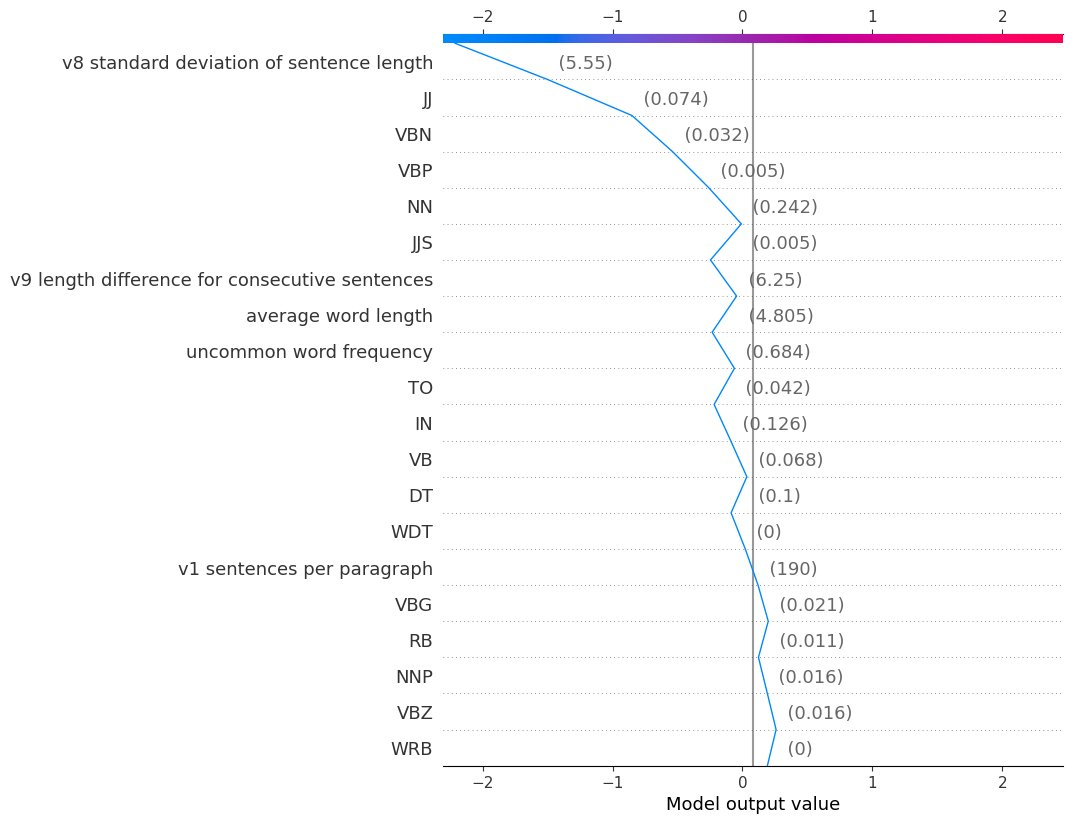

<Figure size 640x480 with 0 Axes>

In [37]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

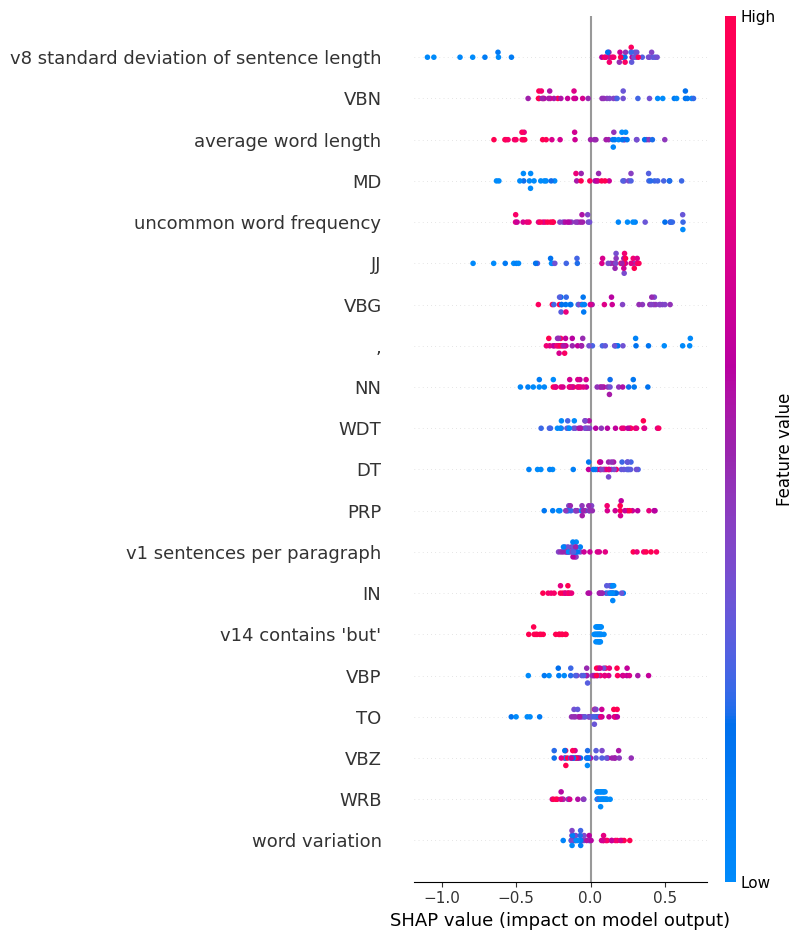

<Figure size 640x480 with 0 Axes>

In [38]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

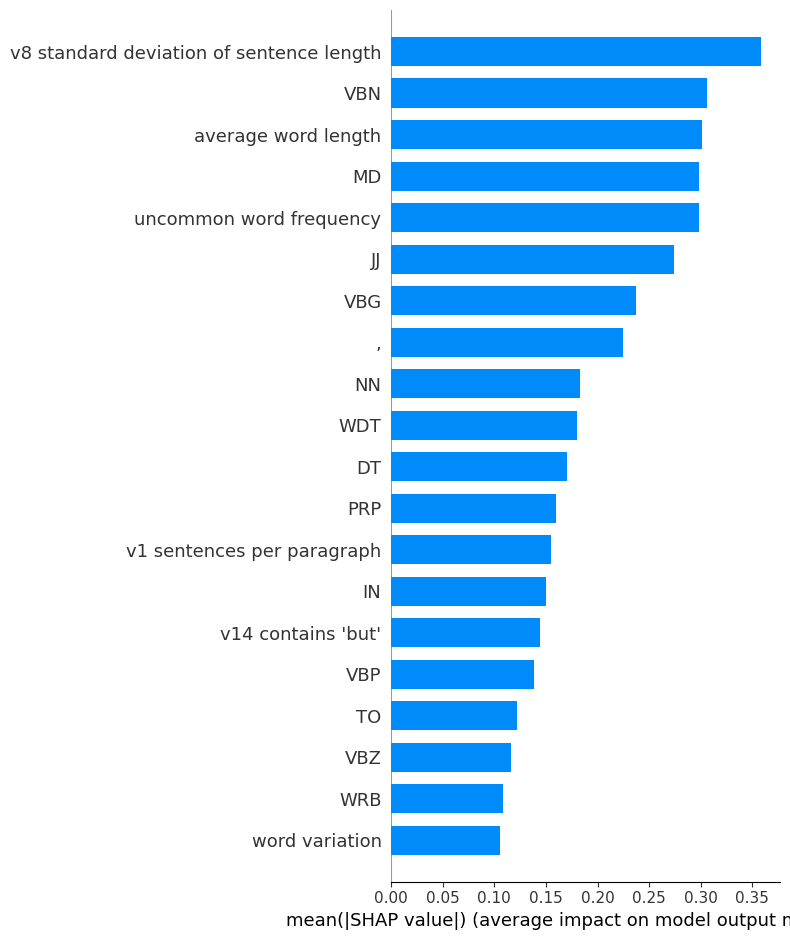

<Figure size 640x480 with 0 Axes>

In [39]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

In [51]:
results: list[TrainingResult] = cv_trainer.train_loocv(source)

[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2075
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2080
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 99, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497487 -> initscore=-0.010050
[LightGBM] [Info] Start training from score -0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2081
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2082
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Total Bins 2079
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 100, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2077
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502513 -> initscore=0.010050
[LightGBM] [Info] Start training from score 0.010050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [52]:
from authorship_tool.util.ml.model import CrossValidationResult


cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(results)

In [53]:
from authorship_tool.util.ml.model import CvGlobalExplanationData


cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [54]:
from authorship_tool.util.ml.model import Score
score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [55]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.16720000000000002
f1 score: 0.27272727272727276
accuracy score: 0.28


In [56]:
from authorship_tool.util.ml.model import pred_crosstab

display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,29,71
True,73,27


In [57]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0

In [58]:
import shap
shap.initjs()

In [59]:
inaugural_loocv_figure_dir_path = VijiniDatasetPaths.shap_figure_dir

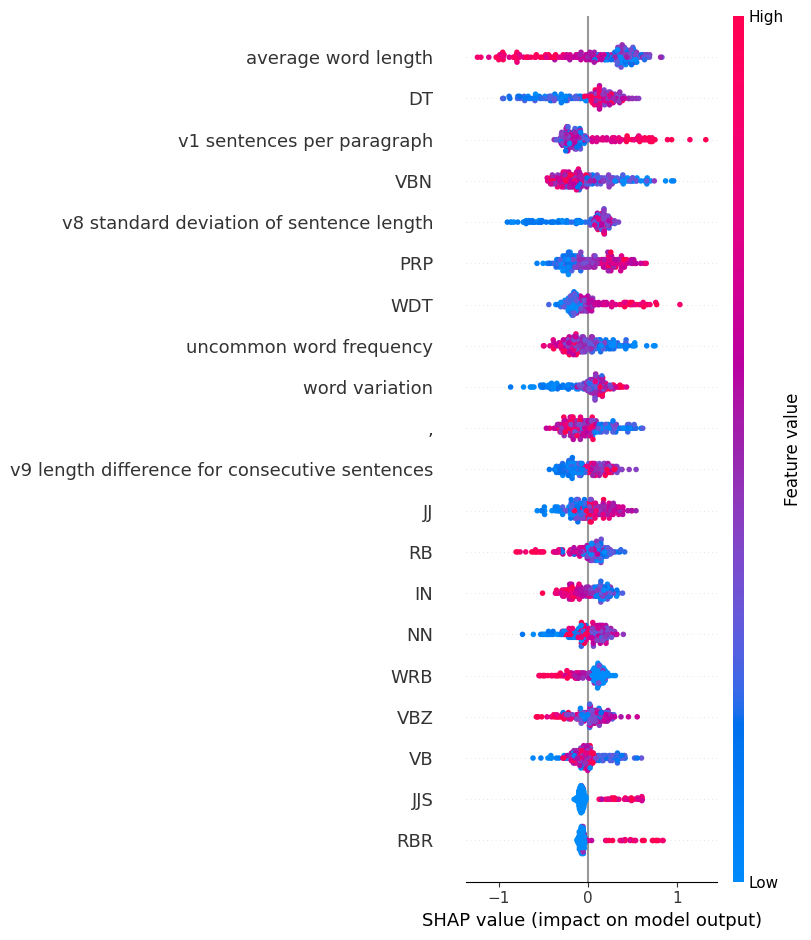

<Figure size 640x480 with 0 Axes>

In [60]:
from matplotlib import pyplot as plt


shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.show()
plt.clf()

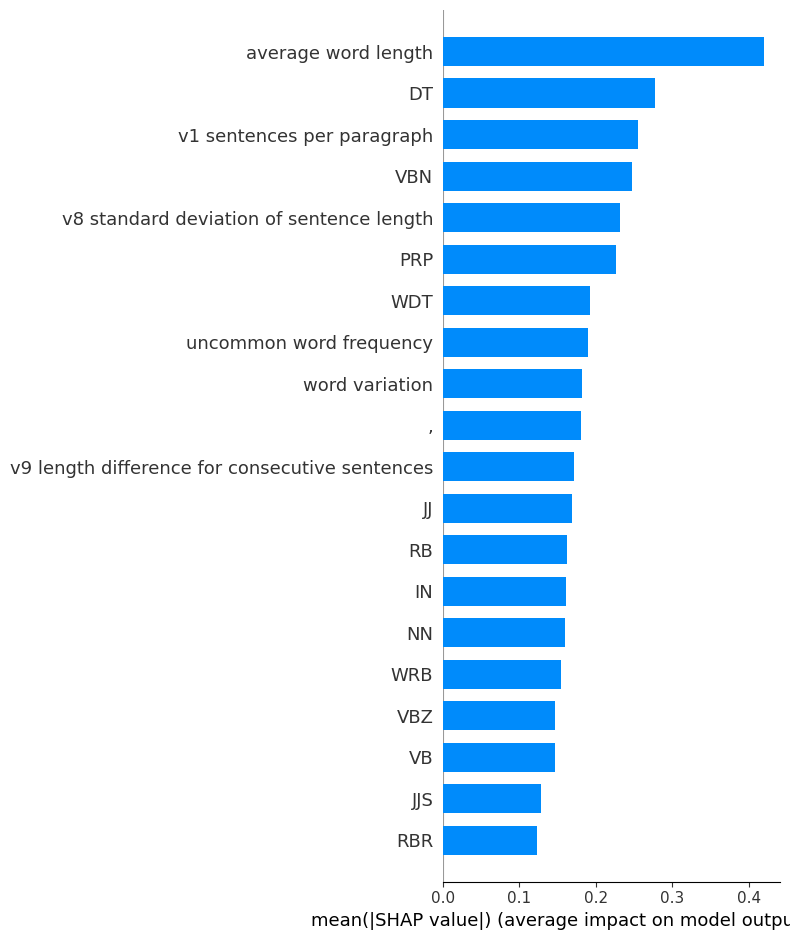

<Figure size 640x480 with 0 Axes>

In [61]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.show()
plt.clf()